# Simple regression predicting goals scored in a high school soccer game
#####  This file conducts a simple linear regression with goals_for as the response variable and attacking_advantage as the explanatory variable

#### Boiler plate stuff

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
from bs4 import BeautifulSoup
import urllib2
from datetime import date,datetime,time
import re
from math import radians, cos, sin, asin, sqrt

import statsmodels.api as sm
import statsmodels.formula.api as smf

### Load the data

In [2]:
games = pd.read_csv('merged_data.csv')

###Create the explanatory variable - attacking advantage
##### attacking advantage is the difference between a teams attacking power and its opponents defensive power.  attacking power is defined as the difference between how many goals a team scores versus its opponents average goals conceeded. in other words, did a team perform better or worse than other teams that played a specific opponent.  that difference is averaged over all games a team has played.  for defensive power, a similar calculation is performed - that is, a team's goals conceded in a game less its opponents average goals scored, averaged over a season. larger positive attacking power is good and large negative defensive power is good.

##### first calculate the average goals scored (goals_for) and average goals conceeded (goals_against) for each team by season

In [3]:
ave = 0
num = 0
ave_goals_for = np.zeros(len(games))/1.0
for i in range(1,len(games)):
    if (games['team'][i] == games['team'][i-1]) & (games['season'][i] == games['season'][i-1]):
        ave = ave + games['goals_for'][i-1].astype(float)
        num = num + 1
        ave_goals_for[i-1] = float(ave/num)
    else:
        ave = ave + games['goals_for'][i-1]
        num = num + 1
        ave_goals_for[i-1] = float(ave/num)
        ave = 0
        num = 0
ave = ave + games['goals_for'][i]
num = num + 1
ave_goals_for[i] = float(ave/num)
games['ave_goals_for'] = ave_goals_for

ave = 0
num = 0
ave_goals_against = np.zeros(len(games))/1.0
for i in range(1,len(games)):
    if (games['team'][i] == games['team'][i-1]) & (games['season'][i] == games['season'][i-1]):
        ave = ave + games['goals_against'][i-1].astype(float)
        num = num + 1
        ave_goals_against[i-1] = float(ave/num)
    else:
        ave = ave + games['goals_against'][i-1]
        num = num + 1
        ave_goals_against[i-1] = float(ave/num)
        ave = 0
        num = 0
ave = ave + games['goals_against'][i]
num = num + 1
ave_goals_against[i] = float(ave/num)
games['ave_goals_against'] = ave_goals_against

##### and get the opponents average goals for and against for each game.  need to mark the last game in the season as this game has the final average for the season

In [4]:
last = np.zeros(len(games))
for i in range(1,len(games)):
    if (games['game_number'][i] == 1):
        last[i-1] = 1
    else:
        last[i-1] = 0
last[i] = 1
games.loc[:,'last_game'] = last

In [5]:
opp_ave_goals_for = []
for i in range(0,len(games)):
    oagf = games[(games['id']== games.opponent_id[i]) & (games['season']== games.season[i]) ]
    c = oagf.loc[games['last_game']== 1,'ave_goals_for']
    if len(c) > 0:
        c = c.iloc[0]
        opp_ave_goals_for.append(c)
    else:
        opp_ave_goals_for.append(0)
games['opp_ave_goals_for'] = opp_ave_goals_for

opp_ave_goals_against = []
for i in range(0,len(games)):
    oaga = games[(games['id']== games.opponent_id[i]) & (games['season']== games.season[i]) ]
    c = oaga.loc[games['last_game']== 1,'ave_goals_against']
    if len(c) > 0:
        c = c.iloc[0]
        opp_ave_goals_against.append(c)
    else:
        opp_ave_goals_against.append(0)
games['opp_ave_goals_against'] = opp_ave_goals_against



##### now calculate the attacking power for each game

In [6]:
games['attacking_power'] = games['goals_for']-games['opp_ave_goals_against']

##### and compute the average attacking power

In [7]:
ave = 0
num = 0
ave_att_pwr = np.zeros(len(games))/1.0
for i in range(1,len(games)):
    if (games['team'][i] == games['team'][i-1]) & (games['season'][i] == games['season'][i-1]):
        ave = ave + games['attacking_power'][i-1].astype(float)
        num = num + 1
        ave_att_pwr[i-1] = float(ave/num)
    else:
        ave = ave + games['attacking_power'][i-1]
        num = num + 1
        ave_att_pwr[i-1] = float(ave/num)
        ave = 0
        num = 0
ave = ave + games['attacking_power'][i]
num = num + 1
ave_att_pwr[i] = float(ave/num)
games['ave_att_pwr'] = ave_att_pwr



##### apply the seasonal attacking power (final average attacking power for the season) for each game in that season

In [8]:
final_att_pwr = np.zeros(len(games))
for i in range(1,len(games)):
    if (games['team'][i] == games['team'][i-1])& (games['season'][i] == games['season'][i-1]):
        look = games[games['id']== games.id[i]]
        look = look[look['season']== games.season[i]]
        last_ap = look.loc[games['last_game']== 1,'ave_att_pwr']
        final_att_pwr[i-1] = last_ap
    else:
        final_att_pwr[i-1] = last_ap
        last_ap = 0
final_att_pwr[i] = last_ap
games['final_att_pwr'] = final_att_pwr


##### now compute the defensive power for each game

In [9]:
games['def_power'] = games['goals_against']-games['opp_ave_goals_for']

##### and compute the average defensive power

In [10]:
ave = 0
num = 0
ave_def_pwr = np.zeros(len(games))/1.0
for i in range(1,len(games)):
    if (games['team'][i] == games['team'][i-1]) & (games['season'][i] == games['season'][i-1]):
        ave = ave + games['def_power'][i-1].astype(float)
        num = num + 1
        ave_def_pwr[i-1] = float(ave/num)
    else:
        ave = ave + games['def_power'][i-1]
        num = num + 1
        ave_def_pwr[i-1] = float(ave/num)
        ave = 0
        num = 0
ave = ave + games['def_power'][i]
num = num + 1
ave_def_pwr[i] = float(ave/num)
games['ave_def_pwr'] = ave_def_pwr



##### apply the seasonal defensive power (final average defensive power for the season) for each game in that season

In [11]:
final_def_pwr = np.zeros(len(games))
for i in range(1,len(games)):
    if (games['team'][i] == games['team'][i-1])& (games['season'][i] == games['season'][i-1]):
        look = games[games['id']== games.id[i]]
        look = look[look['season']== games.season[i]]
        last_dp = look.loc[games['last_game']== 1,'ave_def_pwr']
        final_def_pwr[i-1] = last_dp
    else:
        final_def_pwr[i-1] = last_dp
        last_dp = 0
final_def_pwr[i] = last_dp
games['final_def_pwr'] = final_def_pwr



##### get the opponents attacking and defensive power

In [12]:
opp_att_pwr = []
for i in range(0,len(games)):
    oap = games[(games['id']== games.opponent_id[i]) & (games['season']== games.season[i]) ]
    c = oap.loc[games['last_game']== 1,'final_att_pwr']
    if len(c) > 0:
        c = c.iloc[0]
        opp_att_pwr.append(c)
    else:
        opp_att_pwr.append(0)
games['opp_att_pwr'] = opp_att_pwr

opp_def_pwr = []
for i in range(0,len(games)):
    odp = games[(games['id']== games.opponent_id[i]) & (games['season']== games.season[i]) ]
    c = odp.loc[games['last_game']== 1,'final_def_pwr']
    if len(c) > 0:
        c = c.iloc[0]
        opp_def_pwr.append(c)
    else:
        opp_def_pwr.append(0)
games['opp_def_pwr'] = opp_def_pwr



In [13]:
games['attacking_advantage'] = games['final_att_pwr']+games['opp_def_pwr']

##### center the variable and check that its mean is 0 or close

In [14]:
games['attacking_advantage_c'] = games['attacking_advantage'] - games['attacking_advantage'].mean()

In [15]:
games['attacking_advantage_c'].mean()

7.338353650761281e-16

### Every game is in the database twice... once for each team playing.  So drop of the duplicate entries

In [16]:
games = games.drop_duplicates(subset='contest_id',take_last=True)

### Scatterplots of response (goals_for) vs. explanatory (attacking_advantage)

Axes(0.125,0.125;0.775x0.775)


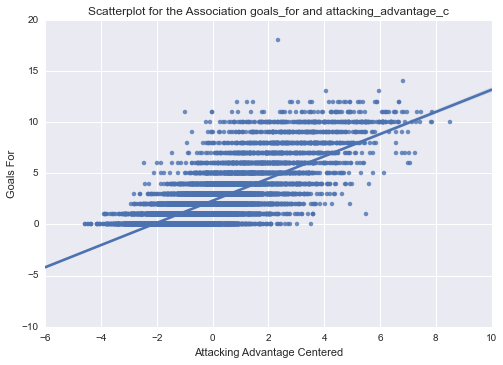

In [17]:
scat1 = sns.regplot(x="attacking_advantage_c", y="goals_for", scatter=True, order=1, data=games)
plt.xlabel('Attacking Advantage Centered')
plt.ylabel('Goals For')
plt.title ('Scatterplot for the Association goals_for and attacking_advantage_c')
print(scat1)



### Linear regression for Goals For and Attacking Advantage

In [18]:
reg1 = smf.ols('goals_for ~ attacking_advantage_c', data=games).fit()
print (reg1.summary())

                            OLS Regression Results                            
Dep. Variable:              goals_for   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                 1.645e+04
Date:                Sat, 27 Feb 2016   Prob (F-statistic):               0.00
Time:                        13:17:02   Log-Likelihood:                -26882.
No. Observations:               13971   AIC:                         5.377e+04
Df Residuals:                   13969   BIC:                         5.378e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 2.32

##### Model fit analysis

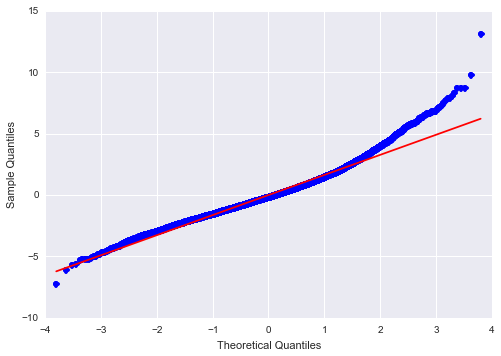

In [19]:
fig1 = sm.qqplot(reg1.resid,line='r')

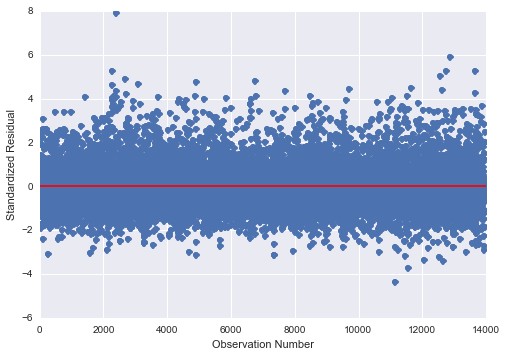

In [20]:
stdres=pd.DataFrame(reg1.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

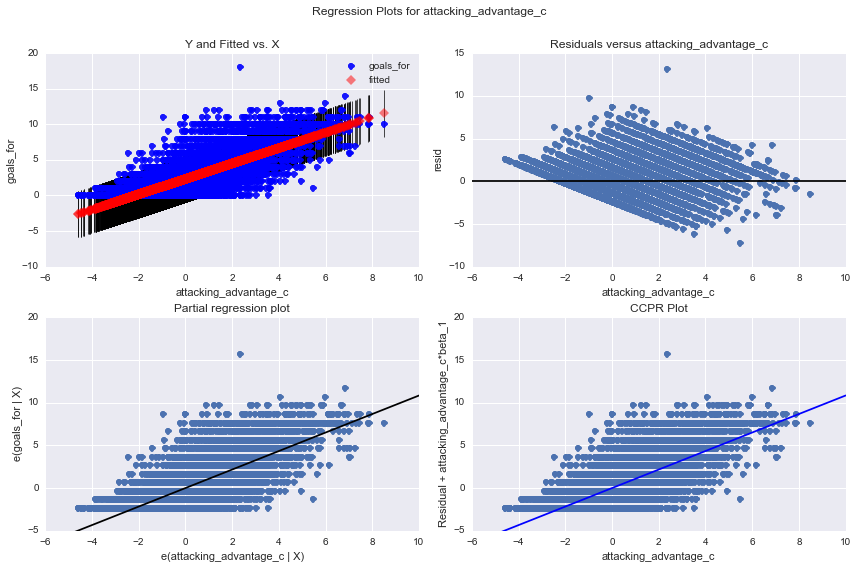

In [21]:
fig2 = plt.figure(figsize=(12,8))
fig2 = sm.graphics.plot_regress_exog(reg1,  "attacking_advantage_c", fig=fig2)



Figure(640x440)


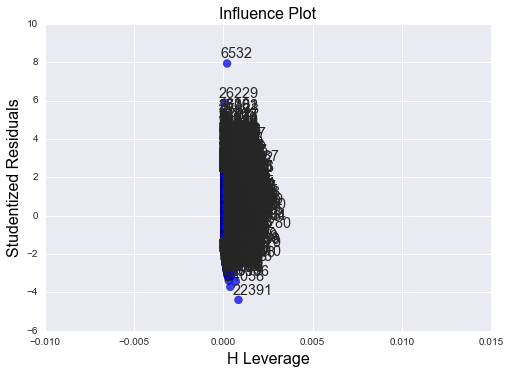

In [22]:
fig3=sm.graphics.influence_plot(reg1, size=8)
print(fig3)

